# Mie Scattering Surrogate Model

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web
import tidy3d.plugins.design as tdd

In [2]:
center = [0, 0, 0]

# permittivity of the sphere
epsr = 4

# Define material properties
air = td.Medium(permittivity=1)
diel = td.Medium(permittivity=epsr)

# resolution control
min_steps_per_wvl = 20

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

# Simulation run time (s)
run_time = 2e-12

# Theta range for far-field
num_theta = 300
thetas = np.linspace(0, np.pi, num_theta)

In [3]:
def make_sim(radius):
    # free space central wavelength
    wavelength = 1.55
    f0 = td.C_0 / wavelength
    ldas = np.linspace(1.50, 1.60, 101)
    freqs = td.C_0 / ldas

    # distance between the surface of the sphere and the start of the PML layers along each cartesian direction
    buffer_PML = 3 * wavelength

    # distance between the sphere and the near field monitor along each cartesian direction
    buffer_mon = 1 * wavelength

    # distance between the sphere and the TFSF source region along each cartesian direction
    buffer_tfsf = 0.5 * wavelength

    # set the domain size in x, y, and z
    domain_size = buffer_PML + 2 * radius + buffer_PML

    # construct simulation size array
    sim_size = (domain_size, domain_size, domain_size)

    # create the sphere
    sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=diel)
    geometry = [sphere]

    # Bandwidth in Hz
    fwidth = f0 / 10.0

    # time dependence of source
    gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

    # place the total-field region around the sphere, injecting a plane wave from the bottom in the +z direction
    source_size = [2 * radius + 2 * buffer_tfsf] * 3
    source = td.TFSF(
        center=center,
        size=source_size,
        source_time=gaussian,
        direction="+",
        pol_angle=0,
        injection_axis=2,
    )

    # set the far-field observation angles of interest
    # phis = np.linspace(0, np.pi / 2, num_phi)
    phi = 0 
    mon_size = 2 * radius + 2 * buffer_mon

    # create the far field monitor for server-side computation of far fields
    monitor_far = td.FieldProjectionAngleMonitor(
        center=center,
        size=[mon_size, mon_size, mon_size],
        freqs=freqs,
        name="far_field",
        custom_origin=center,
        phi=[phi],
        theta=list(thetas),
        far_field_approx=True,  # we leave this to its default value of 'True' because we are interested in fields sufficiently
        # far away that the far field approximations can be invoked to speed up the calculation
    )

    # create the phantom override structure for the mesh based on the TFSF source size
    mesh_override = td.Structure(
        geometry=td.Box(center=source.center, size=[i * 1.1 for i in source.size]),
        medium=diel,
    )
    grid_spec = td.GridSpec.auto(
        min_steps_per_wvl=min_steps_per_wvl, override_structures=[mesh_override]
    )

    # create the simulation object
    sim = td.Simulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=geometry,
        sources=[source],
        monitors=[monitor_far],
        run_time=run_time,
        boundary_spec=boundary_spec,
    )

    return sim

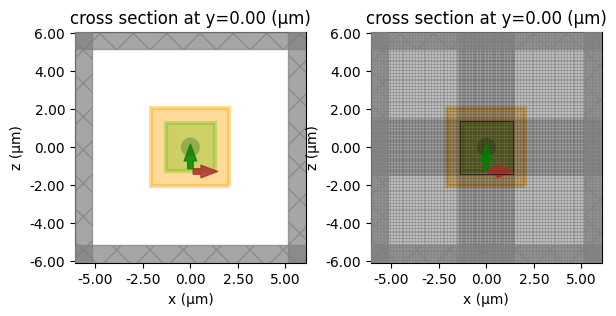

In [4]:
sim = make_sim(0.5)
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
sim.plot(y=0, ax=ax[0])
sim.plot(y=0, ax=ax[1])
sim.plot_grid(y=0, ax=ax[1])
plt.show()

In [5]:
def fn_post(sim_data):
    return sim_data["far_field"]

In [6]:
method = tdd.MethodMonteCarlo(
    num_points=100,
    seed=1,
)

r_param = tdd.ParameterFloat(name="radius", span=(0.5, 2.5))
parameters = [r_param]

output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mie/data"
design_space = tdd.DesignSpace(
    method=method,
    parameters=parameters,
    task_name="mie_1",
    folder_name="mieV1",
    path_dir=output_dir,
)


In [ ]:
results = design_space.run(make_sim, fn_post, verbose=True)
df = results.to_dataframe()

In [7]:
# TESTING: Save off the df or load the df
import pickle
import os
os.chdir("/home/matt/Documents/Flexcompute/surrogate_data/mie/data")
# with open("result_100.pkl", "wb") as out_file:
#     pickle.dump(results, out_file)


with open("result_100.pkl", "rb") as in_file:
    results = pickle.load(in_file)

df = results.to_dataframe()

## Surrogate

In [8]:
expanded_df = df.copy()
expanded_df["rcs"] = expanded_df["output"].apply(lambda x: np.real(x.radar_cross_section).sel(phi=0, r=1e6))
expanded_df["central_rcs"] = expanded_df["rcs"].apply(lambda x: x.sel(f= td.C_0 / 1.55).values)
expanded_df["total_rcs"] = expanded_df["central_rcs"].apply(lambda x: x.sum())
expanded_df["freq"] = td.C_0 / 1.55

# expanded_df["rcs_by_f"] = expanded_df["rcs"].apply(lambda x: x.transpose("f", ...))
# expanded_df.drop(["rcs", "output"], axis=1, inplace=True)
# expanded_df = expanded_df.explode(["rcs_by_f"]).reset_index(drop=True)
# expanded_df["freq"] = expanded_df["rcs_by_f"].apply(lambda x: float(x.f))
# expanded_df["rcs_by_f"] = expanded_df["rcs_by_f"].apply(lambda x: x.values)

# # Single value output
# expanded_df["total_rcs"] = expanded_df["rcs_by_f"].apply(lambda x: x.sum())


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

from tidy3d.plugins.design.surrogate_object import AI_Model

# Constants
output_dir = "/home/matt/Documents/Flexcompute/surrogate_data/mie"
data_dir = ["/home/matt/Documents/Flexcompute/surrogate_data/mie/data/"]

test_percentage = 0.20
valid_percentage = 0.20
batch_size = 256
epochs = 150

trial_count = 50

model = AI_Model(output_dir, data_dir, seed=2)

model.load_data_from_df(
    df=expanded_df,
    label_names=["total_rcs"],
    feature_names=["radius", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True,
    label_as_array=False
)

loss_fn = nn.MSELoss()


Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


In [14]:
# Define the model in PyTorch
class VariableANN(nn.Module):
    def __init__(self, input_size, neurons, dropout) -> None:
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, neurons[0]))

        for i in range(1, len(neurons)):
            self.layers.append(nn.Linear(neurons[i - 1], neurons[i]))

        self.layers.append(nn.Linear(neurons[-1], 1))

        self.drop = nn.Dropout(dropout)
        self.relu = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.drop(self.relu(layer(x)))

        x = self.layers[-1](x)

        return x

Using existing directory at Model1


 71%|███████   | 71/100 [00:00<00:00, 703.96it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 1
Best State Updated. Epoch: 2
Best State Updated. Epoch: 3
Best State Updated. Epoch: 4
Best State Updated. Epoch: 5
Best State Updated. Epoch: 6
Best State Updated. Epoch: 7
Best State Updated. Epoch: 8
Best State Updated. Epoch: 9
Best State Updated. Epoch: 10
Best State Updated. Epoch: 11
Best State Updated. Epoch: 12
Best State Updated. Epoch: 13
Best State Updated. Epoch: 14
Best State Updated. Epoch: 15
Best State Updated. Epoch: 16
Best State Updated. Epoch: 17
Best State Updated. Epoch: 18
Best State Updated. Epoch: 19
Best State Updated. Epoch: 20
Best State Updated. Epoch: 21
Best State Updated. Epoch: 22
Best State Updated. Epoch: 23
Best State Updated. Epoch: 24
Best State Updated. Epoch: 25
Best State Updated. Epoch: 26
Best State Updated. Epoch: 27
Best State Updated. Epoch: 28
Best State Updated. Epoch: 29
Best State Updated. Epoch: 30
Best State Updated. Epoch: 31
Best State Updated. Epoch: 32
Best State Updated. 

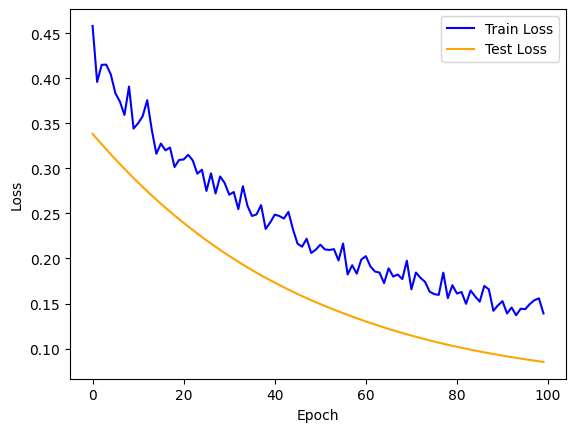

100%|██████████| 100/100 [00:00<00:00, 559.44it/s]

 Best Test Loss: 0.08516327291727066
RMSE: 15385.953486
MAE: 11390.417352


In [15]:
network = VariableANN(2, [4, 4, 4], 0.2)
opt = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.0001)

trained_net = model.train_model("Model1", network, opt, loss_fn, 100, plot_output=True)
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")


[I 2024-09-19 11:00:40,930] A new study created in memory with name: no-name-745e0f71-4b2d-4329-b9fe-0f8a1817e7dd


Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 772.23it/s]
[I 2024-09-19 11:00:41,133] Trial 0 finished with value: 7154.476923 and parameters: {'dropout': 0.2, 'neurons0': 32, 'neurons1': 160, 'neurons2': 128, 'lr': 0.00048025424062174367, 'weight_decay': 4.577935210544098e-05}. Best is trial 0 with value: 7154.476923.


 Best Test Loss: 0.01703183725476265
RMSE: 7154.476923
MAE: 5804.066414
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 838.89it/s]
[I 2024-09-19 11:00:41,316] Trial 1 finished with value: 5927.678666 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 96, 'neurons2': 96, 'lr': 0.003051654279698752, 'weight_decay': 0.00011436264429175036}. Best is trial 1 with value: 5927.678666.


 Best Test Loss: 0.011464769951999187
RMSE: 5927.678666
MAE: 4792.348679
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 844.91it/s]
[I 2024-09-19 11:00:41,499] Trial 2 finished with value: 4191.543438 and parameters: {'dropout': 0.05, 'neurons0': 160, 'neurons1': 64, 'neurons2': 224, 'lr': 0.026055605528320886, 'weight_decay': 9.738087550542687e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.005687014665454626
RMSE: 4191.543438
MAE: 3567.388617
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 765.86it/s]
[I 2024-09-19 11:00:41,702] Trial 3 finished with value: 7371.212514 and parameters: {'dropout': 0.45, 'neurons0': 32, 'neurons1': 160, 'neurons2': 32, 'lr': 0.000515809468917109, 'weight_decay': 1.5597745550530742e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.018213218078017235
RMSE: 7371.212514
MAE: 6141.899254
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 827.47it/s]
[I 2024-09-19 11:00:41,888] Trial 4 finished with value: 7293.793933 and parameters: {'dropout': 0.05, 'neurons0': 160, 'neurons1': 64, 'neurons2': 32, 'lr': 7.607199893010989e-05, 'weight_decay': 5.007864506258199e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.019138609990477562
RMSE: 7293.793933
MAE: 6055.461648
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 860.62it/s]
[I 2024-09-19 11:00:42,067] Trial 5 finished with value: 7636.993173 and parameters: {'dropout': 0.25, 'neurons0': 64, 'neurons1': 192, 'neurons2': 128, 'lr': 0.001049414063663077, 'weight_decay': 5.939984370303656e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.01717209629714489
RMSE: 7636.993173
MAE: 6221.434387
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 877.93it/s]
[I 2024-09-19 11:00:42,242] Trial 6 finished with value: 14359.381996 and parameters: {'dropout': 0.4, 'neurons0': 160, 'neurons1': 64, 'neurons2': 192, 'lr': 0.0721446814835575, 'weight_decay': 0.00010000385053531142}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07289654016494751
RMSE: 14359.381996
MAE: 12000.520301
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 854.02it/s]
[I 2024-09-19 11:00:42,422] Trial 7 finished with value: 7152.934132 and parameters: {'dropout': 0.45, 'neurons0': 96, 'neurons1': 160, 'neurons2': 128, 'lr': 0.0005584561167436292, 'weight_decay': 0.0003573702286308227}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.017209947109222412
RMSE: 7152.934132
MAE: 5848.867183
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 907.25it/s]
[I 2024-09-19 11:00:42,592] Trial 8 finished with value: 7218.001467 and parameters: {'dropout': 0.25, 'neurons0': 256, 'neurons1': 160, 'neurons2': 32, 'lr': 0.00029199109496504637, 'weight_decay': 0.000503154090821944}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.017020417377352715
RMSE: 7218.001467
MAE: 5858.207769
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 912.79it/s]
[I 2024-09-19 11:00:42,760] Trial 9 finished with value: 5459.835687 and parameters: {'dropout': 0.2, 'neurons0': 32, 'neurons1': 64, 'neurons2': 32, 'lr': 0.09449482948657142, 'weight_decay': 0.0008732943024748074}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.0078011127188801765
RMSE: 5459.835687
MAE: 4825.758109
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 905.39it/s]
[I 2024-09-19 11:00:42,938] Trial 10 finished with value: 4734.656432 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 256, 'neurons2': 256, 'lr': 0.011167754394005493, 'weight_decay': 1.4352521472349245e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.008064555935561657
RMSE: 4734.656432
MAE: 3891.192621
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 926.05it/s]
[I 2024-09-19 11:00:43,113] Trial 11 finished with value: 5487.929055 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 256, 'neurons2': 256, 'lr': 0.008972696353255424, 'weight_decay': 1.5018915300888728e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.010622302070260048
RMSE: 5487.929055
MAE: 4517.418646
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 854.77it/s]
[I 2024-09-19 11:00:43,302] Trial 12 finished with value: 14269.47157 and parameters: {'dropout': 0.1, 'neurons0': 224, 'neurons1': 256, 'neurons2': 256, 'lr': 0.015208859459424802, 'weight_decay': 1.0060768109543128e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07288334518671036
RMSE: 14269.47157
MAE: 11646.625769
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 815.06it/s]
[I 2024-09-19 11:00:43,499] Trial 13 finished with value: 14292.83851 and parameters: {'dropout': 0.0, 'neurons0': 192, 'neurons1': 32, 'neurons2': 192, 'lr': 1.0784522836544608e-05, 'weight_decay': 0.00025924943795891124}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07349207252264023
RMSE: 14292.83851
MAE: 10410.89743
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 852.58it/s]
[I 2024-09-19 11:00:43,689] Trial 14 finished with value: 14508.690776 and parameters: {'dropout': 0.1, 'neurons0': 128, 'neurons1': 224, 'neurons2': 224, 'lr': 0.02438429139729447, 'weight_decay': 2.581727594830858e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07288505882024765
RMSE: 14508.690776
MAE: 12366.621082
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 810.50it/s]

 Best Test Loss: 0.01580708660185337
RMSE: 6721.229119
MAE: 5406.642863



[I 2024-09-19 11:00:43,887] Trial 15 finished with value: 6721.229119 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 256, 'neurons1': 96, 'neurons2': 192, 'lr': 0.002795386467956793, 'weight_decay': 0.00018997720250423628}. Best is trial 2 with value: 4191.543438.


Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 870.55it/s]
[I 2024-09-19 11:00:44,073] Trial 16 finished with value: 4978.443074 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 192, 'neurons1': 128, 'neurons2': 224, 'lr': 0.0054253190289179675, 'weight_decay': 3.814223347738606e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.00884247850626707
RMSE: 4978.443074
MAE: 4074.983034
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 740.27it/s]
[I 2024-09-19 11:00:44,288] Trial 17 finished with value: 14301.604166 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 224, 'neurons2': 224, 'lr': 0.028885753423833548, 'weight_decay': 0.0001606627476017174}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07288379967212677
RMSE: 14301.604166
MAE: 11799.242957
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 856.76it/s]
[I 2024-09-19 11:00:44,476] Trial 18 finished with value: 8172.375538 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 32, 'neurons2': 256, 'lr': 0.0365285978815244, 'weight_decay': 2.6426826087970298e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.005198822356760502
RMSE: 8172.375538
MAE: 7251.187517
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 803.43it/s]

 Best Test Loss: 0.01784387417137623



[I 2024-09-19 11:00:44,677] Trial 19 finished with value: 7210.622944 and parameters: {'dropout': 0.35000000000000003, 'neurons0': 224, 'neurons1': 128, 'neurons2': 160, 'lr': 0.002176665919392124, 'weight_decay': 7.676770435690144e-05}. Best is trial 2 with value: 4191.543438.


RMSE: 7210.622944
MAE: 5807.428766
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 825.44it/s]
[I 2024-09-19 11:00:44,872] Trial 20 finished with value: 5891.070033 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 96, 'neurons1': 224, 'neurons2': 224, 'lr': 0.009030429369141361, 'weight_decay': 2.6710584584191764e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.012232533656060696
RMSE: 5891.070033
MAE: 4808.81166
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 864.80it/s]
[I 2024-09-19 11:00:45,059] Trial 21 finished with value: 5190.574701 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 192, 'neurons1': 128, 'neurons2': 224, 'lr': 0.006324099715493361, 'weight_decay': 3.407437287720634e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.00969246681779623
RMSE: 5190.574701
MAE: 4299.93791
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 815.52it/s]
[I 2024-09-19 11:00:45,256] Trial 22 finished with value: 5060.659417 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 96, 'neurons2': 256, 'lr': 0.0062078543261635385, 'weight_decay': 1.5585056423163736e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.009213351644575596
RMSE: 5060.659417
MAE: 4120.76704
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 866.81it/s]
[I 2024-09-19 11:00:45,444] Trial 23 finished with value: 5898.345802 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 224, 'neurons1': 192, 'neurons2': 160, 'lr': 0.01747270949649311, 'weight_decay': 7.528636331781984e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.01010196190327406
RMSE: 5898.345802
MAE: 4745.508563
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 789.66it/s]
[I 2024-09-19 11:00:45,649] Trial 24 finished with value: 10679.74932 and parameters: {'dropout': 0.05, 'neurons0': 160, 'neurons1': 128, 'neurons2': 192, 'lr': 0.05613892247678618, 'weight_decay': 3.655803756672838e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.0036238746251910925
RMSE: 10679.74932
MAE: 6509.076756
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 854.72it/s]
[I 2024-09-19 11:00:45,841] Trial 25 finished with value: 6580.645923 and parameters: {'dropout': 0.1, 'neurons0': 256, 'neurons1': 192, 'neurons2': 224, 'lr': 0.0017985624036200728, 'weight_decay': 1.2132115276650393e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.015339599922299385
RMSE: 6580.645923
MAE: 5270.110708
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 795.55it/s]
[I 2024-09-19 11:00:46,044] Trial 26 finished with value: 4956.063036 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 96, 'neurons2': 256, 'lr': 0.005158480710472497, 'weight_decay': 2.0665655437208112e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.008836434222757816
RMSE: 4956.063036
MAE: 4061.718123
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 847.67it/s]
[I 2024-09-19 11:00:46,234] Trial 27 finished with value: 5440.900987 and parameters: {'dropout': 0.0, 'neurons0': 96, 'neurons1': 64, 'neurons2': 256, 'lr': 0.014797618042206686, 'weight_decay': 2.1789189285470017e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.010649888776242733
RMSE: 5440.900987
MAE: 4397.278379
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 800.86it/s]
[I 2024-09-19 11:00:46,436] Trial 28 finished with value: 14307.383718 and parameters: {'dropout': 0.0, 'neurons0': 128, 'neurons1': 96, 'neurons2': 256, 'lr': 0.04223609036149483, 'weight_decay': 1.9946116019931016e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.0728842243552208
RMSE: 14307.383718
MAE: 11822.483582
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 842.78it/s]
[I 2024-09-19 11:00:46,629] Trial 29 finished with value: 7756.778996 and parameters: {'dropout': 0.2, 'neurons0': 64, 'neurons1': 32, 'neurons2': 160, 'lr': 0.0001401819949984684, 'weight_decay': 0.00014349810433751106}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.021645432338118553
RMSE: 7756.778996
MAE: 6491.225656
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 779.30it/s]
[I 2024-09-19 11:00:46,837] Trial 30 finished with value: 7343.552365 and parameters: {'dropout': 0.05, 'neurons0': 96, 'neurons1': 96, 'neurons2': 96, 'lr': 0.0009809189852292954, 'weight_decay': 5.551888700952945e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.01720193587243557
RMSE: 7343.552365
MAE: 5955.827202
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 792.09it/s]
[I 2024-09-19 11:00:47,041] Trial 31 finished with value: 5121.502963 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 128, 'neurons2': 224, 'lr': 0.005040176144791591, 'weight_decay': 3.7312124892607254e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.00927935540676117
RMSE: 5121.502963
MAE: 4162.810857
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 860.08it/s]
[I 2024-09-19 11:00:47,230] Trial 32 finished with value: 5906.168547 and parameters: {'dropout': 0.1, 'neurons0': 160, 'neurons1': 64, 'neurons2': 256, 'lr': 0.003641310505628526, 'weight_decay': 1.011197320324928e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.012549175880849361
RMSE: 5906.168547
MAE: 4968.829964
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 828.24it/s]
[I 2024-09-19 11:00:47,426] Trial 33 finished with value: 5768.544129 and parameters: {'dropout': 0.2, 'neurons0': 128, 'neurons1': 128, 'neurons2': 224, 'lr': 0.009966087797908361, 'weight_decay': 1.8073709207599533e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.010886765085160732
RMSE: 5768.544129
MAE: 4735.20384
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 700.60it/s]
[I 2024-09-19 11:00:47,654] Trial 34 finished with value: 6138.387935 and parameters: {'dropout': 0.15000000000000002, 'neurons0': 160, 'neurons1': 96, 'neurons2': 192, 'lr': 0.004225356541229867, 'weight_decay': 4.3059073529994866e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.013217872940003872
RMSE: 6138.387935
MAE: 4928.212909
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 849.78it/s]
[I 2024-09-19 11:00:47,845] Trial 35 finished with value: 4959.113855 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 96, 'neurons2': 256, 'lr': 0.020665180356300078, 'weight_decay': 7.991959648715571e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.008847317658364773
RMSE: 4959.113855
MAE: 4040.638716
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 871.13it/s]
[I 2024-09-19 11:00:48,033] Trial 36 finished with value: 14302.980173 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 64, 'neurons2': 256, 'lr': 0.025163249048526636, 'weight_decay': 7.754996163759777e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07288366556167603
RMSE: 14302.980173
MAE: 11804.812293
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 878.68it/s]
[I 2024-09-19 11:00:48,218] Trial 37 finished with value: 5788.217765 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 96, 'neurons2': 256, 'lr': 0.0012943717474637822, 'weight_decay': 0.00011986997433860452}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.012052944861352444
RMSE: 5788.217765
MAE: 4712.178256
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 851.98it/s]
[I 2024-09-19 11:00:48,408] Trial 38 finished with value: 6529.67695 and parameters: {'dropout': 0.05, 'neurons0': 224, 'neurons1': 32, 'neurons2': 64, 'lr': 0.06535654803697201, 'weight_decay': 0.00021293177439021355}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.00677115935832262
RMSE: 6529.67695
MAE: 5758.452698
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 806.67it/s]

 Best Test Loss: 0.01605096086859703



[I 2024-09-19 11:00:48,609] Trial 39 finished with value: 6695.496963 and parameters: {'dropout': 0.5, 'neurons0': 64, 'neurons1': 64, 'neurons2': 256, 'lr': 0.011033377561274467, 'weight_decay': 0.00033951968965334256}. Best is trial 2 with value: 4191.543438.


RMSE: 6695.496963
MAE: 5566.279724
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 800.25it/s]

 Best Test Loss: 0.0728827640414238



[I 2024-09-19 11:00:48,812] Trial 40 finished with value: 14338.734848 and parameters: {'dropout': 0.30000000000000004, 'neurons0': 160, 'neurons1': 192, 'neurons2': 192, 'lr': 0.02274435782813256, 'weight_decay': 0.00010514263811105143}. Best is trial 2 with value: 4191.543438.


RMSE: 14338.734848
MAE: 11935.433777
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 811.16it/s]
[I 2024-09-19 11:00:49,013] Trial 41 finished with value: 5163.630369 and parameters: {'dropout': 0.1, 'neurons0': 192, 'neurons1': 160, 'neurons2': 224, 'lr': 0.006935528617410163, 'weight_decay': 6.534280925721342e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.009592100977897644
RMSE: 5163.630369
MAE: 4164.02329
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 858.38it/s]
[I 2024-09-19 11:00:49,202] Trial 42 finished with value: 5214.123192 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 96, 'neurons2': 224, 'lr': 0.013078667308687118, 'weight_decay': 4.7286638405142614e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.009780612774193287
RMSE: 5214.123192
MAE: 4213.913642
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 935.17it/s]
[I 2024-09-19 11:00:49,377] Trial 43 finished with value: 17826.953113 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 128, 'neurons2': 256, 'lr': 0.044880019276200424, 'weight_decay': 1.2658657858669412e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.04431946948170662
RMSE: 17826.953113
MAE: 13286.454904
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 793.92it/s]
[I 2024-09-19 11:00:49,581] Trial 44 finished with value: 15623.888292 and parameters: {'dropout': 0.05, 'neurons0': 160, 'neurons1': 160, 'neurons2': 224, 'lr': 0.09769895027390435, 'weight_decay': 3.140134040686432e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.0728837177157402
RMSE: 15623.888292
MAE: 13858.073037
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 808.68it/s]

 Best Test Loss: 0.05623931437730789



[I 2024-09-19 11:00:49,782] Trial 45 finished with value: 12503.116294 and parameters: {'dropout': 0.1, 'neurons0': 128, 'neurons1': 64, 'neurons2': 256, 'lr': 1.4545480314897348e-05, 'weight_decay': 9.268234463843945e-05}. Best is trial 2 with value: 4191.543438.


RMSE: 12503.116294
MAE: 10297.411609
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 765.61it/s]
[I 2024-09-19 11:00:49,994] Trial 46 finished with value: 6872.68758 and parameters: {'dropout': 0.0, 'neurons0': 224, 'neurons1': 96, 'neurons2': 192, 'lr': 0.0005441299174993681, 'weight_decay': 2.0651022689381016e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.0169924758374691
RMSE: 6872.68758
MAE: 5524.560237
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 804.26it/s]
[I 2024-09-19 11:00:50,197] Trial 47 finished with value: 14294.765201 and parameters: {'dropout': 0.0, 'neurons0': 256, 'neurons1': 128, 'neurons2': 96, 'lr': 0.02042006919477288, 'weight_decay': 4.4916562349677006e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.07288309931755066
RMSE: 14294.765201
MAE: 11770.665515
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 854.27it/s]
[I 2024-09-19 11:00:50,400] Trial 48 finished with value: 6921.252053 and parameters: {'dropout': 0.25, 'neurons0': 192, 'neurons1': 96, 'neurons2': 224, 'lr': 0.0025569572219464763, 'weight_decay': 0.0001246366411640468}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.01641801930963993
RMSE: 6921.252053
MAE: 5571.007932
Making temp model folder
Using existing directory at temp


100%|██████████| 150/150 [00:00<00:00, 691.25it/s]
[I 2024-09-19 11:00:50,632] Trial 49 finished with value: 5184.550954 and parameters: {'dropout': 0.05, 'neurons0': 192, 'neurons1': 256, 'neurons2': 256, 'lr': 0.004254046862142631, 'weight_decay': 5.867560630528975e-05}. Best is trial 2 with value: 4191.543438.


 Best Test Loss: 0.009669983759522438
RMSE: 5184.550954
MAE: 4231.450764
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  0
  Number of complete trials:  50
Best trial:
  Value:  4191.543438
  Params: 
    dropout: 0.05
    neurons0: 160
    neurons1: 64
    neurons2: 224
    lr: 0.026055605528320886
    weight_decay: 9.738087550542687e-05
Using existing directory at Model1


  1%|          | 74/10000 [00:00<00:13, 736.40it/s]

Best State Updated. Epoch: 0
Best State Updated. Epoch: 2
Best State Updated. Epoch: 6
Best State Updated. Epoch: 14
Best State Updated. Epoch: 18
Best State Updated. Epoch: 26
Best State Updated. Epoch: 27
Best State Updated. Epoch: 31
Best State Updated. Epoch: 35
Best State Updated. Epoch: 40
Best State Updated. Epoch: 48
Best State Updated. Epoch: 56
Best State Updated. Epoch: 64
Best State Updated. Epoch: 67
Best State Updated. Epoch: 96
Best State Updated. Epoch: 101


  2%|▏         | 155/10000 [00:00<00:12, 775.43it/s]

Best State Updated. Epoch: 154


  2%|▏         | 243/10000 [00:00<00:11, 822.55it/s]

Best State Updated. Epoch: 157
Best State Updated. Epoch: 221
Best State Updated. Epoch: 241
Best State Updated. Epoch: 302
Best State Updated. Epoch: 303


 81%|████████▏ | 8130/10000 [00:09<00:02, 873.28it/s]

Best State Updated. Epoch: 8024


 99%|█████████▉| 9928/10000 [00:11<00:00, 901.16it/s]

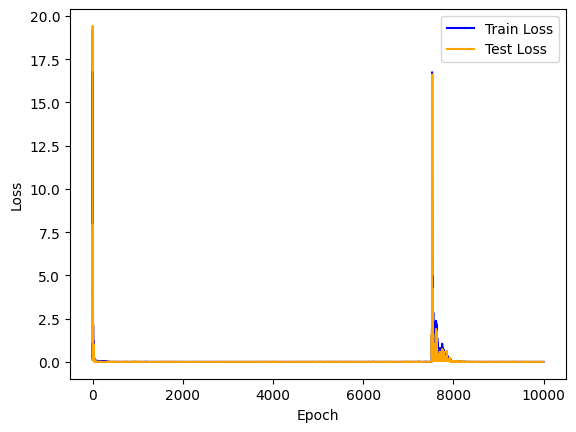

100%|██████████| 10000/10000 [00:11<00:00, 866.98it/s]

 Best Test Loss: 0.002717705210670829


In [16]:
# Optimize model

network_dict = {
    "network": VariableANN,
    "kwargs": {"input_size": 2},
    "optimize_kwargs": {
        "dropout": {"name": "dropout", "low": 0.0, "high": 0.5, "step": 0.05},
        "neurons": {"name": "neurons", "low": 32, "high": 256, "step": 32, "multi": np.random.randint(3, 6)},
    },
}


optimizer_dict = {
    "optimizer": optim.Adam,
    "kwargs": {},
    "optimize_kwargs": {
        "lr": {"name": "lr", "low": 1e-5, "high": 1e-1, "log": True},
        "weight_decay": {"name": "weight_decay", "low": 1e-5, "high": 1e-3, "log": True},
    },
}

best_network, best_optimizer = model.optimize_network(
    trial_count, "minimize", network_dict, optimizer_dict, loss_fn, epochs
)

trained_net = model.train_model("Model1", best_network, best_optimizer, loss_fn, 10000, plot_output=True)

In [17]:
test_rmse, _, test_predictions = model.validate_model(trained_net, "test")
print(f"Mean: {model.test_labels.mean():.3f}, Percent Error: {test_rmse / model.test_labels.mean() * 100:.2f}")

RMSE: 4721.177442
MAE: 3410.11486
Mean: 19722.279, Percent Error: 23.94


In [ ]:
# Used for plotting full size spectra
index = 15
thetas = np.linspace(0, np.pi, num_theta)

test_rmse, _, test_predictions = model.validate_model(trained_net, "test")

def to_db(val):
    return 10.0 * np.log10(val)


fig, ax = plt.subplots(figsize=(7.5, 5))
ax.plot(thetas, to_db(model.test_labels[index]), "--g", label="Real")
ax.plot(thetas, to_db(test_predictions[index]), "--b", label="Predicted")
ax.set(
    xlabel="$\\theta$ (degrees)",
    ylabel="Bistatic RCS (dBs$\\mu$m)",
    yscale="linear",
    xscale="linear",
)
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.legend(loc="best", prop={"size": 14})
plt.tight_layout()

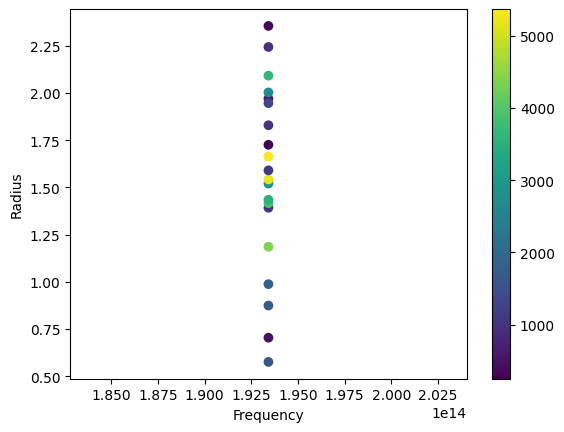

In [21]:
# Used for plotting radius and frequency for summed rcs
test_radii = model.feature_scaler[0].inverse_transform(model.test_loaded.dataset.x[:, 0].reshape(-1, 1))
test_freq = model.feature_scaler[1].inverse_transform(model.test_loaded.dataset.x[:, 1].reshape(-1, 1))
abs_dif = np.abs(model.test_labels - test_predictions)

predict_scatter = plt.scatter(test_freq, test_radii, c=abs_dif)
plt.xlabel("Frequency")
plt.ylabel("Radius")
plt.colorbar(predict_scatter)
plt.show()

Using existing directory at pickle_data
Using existing directory at models
Using device cuda:0


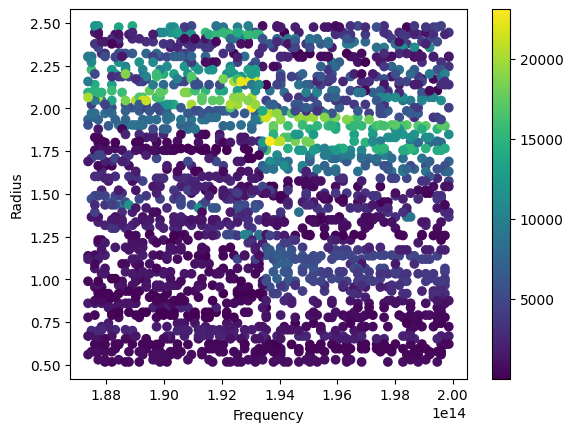

In [18]:
expanded_df = df.copy()
expanded_df["rcs"] = expanded_df["output"].apply(lambda x: np.real(x.radar_cross_section).sel(phi=0, r=1e6))
expanded_df["rcs_by_f"] = expanded_df["rcs"].apply(lambda x: x.transpose("f", ...))
expanded_df.drop(["rcs", "output"], axis=1, inplace=True)
expanded_df = expanded_df.explode(["rcs_by_f"]).reset_index(drop=True)
expanded_df["freq"] = expanded_df["rcs_by_f"].apply(lambda x: float(x.f))
expanded_df["rcs_by_f"] = expanded_df["rcs_by_f"].apply(lambda x: x.values)

# Single value output
expanded_df["total_rcs"] = expanded_df["rcs_by_f"].apply(lambda x: x.sum())

test_model = AI_Model(output_dir, data_dir, seed=2)

test_model.load_data_from_df(
    df=expanded_df,
    label_names=["total_rcs"],
    feature_names=["radius", "freq"],
    test_percentage=test_percentage,
    valid_percentage=valid_percentage,
    batch_size=batch_size,
    individual_feature_scaling=True,
    label_as_array=True
)

test_radii = test_model.feature_scaler[0].inverse_transform(test_model.test_loaded.dataset.x[:, 0].reshape(-1, 1))
test_freq = test_model.feature_scaler[1].inverse_transform(test_model.test_loaded.dataset.x[:, 1].reshape(-1, 1))

def pred(radius, freq):
    feature_array = np.array((radius, freq))
    feature_array = feature_array.reshape((1, -1))
    prediction = model.make_prediction(trained_net, True, feature_array, 1)

    return prediction

pred_out = []
for rad, freq in zip(test_radii, test_freq):
    pred_out.append(pred(rad, freq))

abs_dif = np.abs(test_model.test_labels - np.array(pred_out))
# rad_out = []
# freq_out = []
# pred_out = []
# for rad in np.linspace(0.5, 2.5, 101):
#     for freq in td.C_0 / np.linspace(1.50, 1.60, 101):
#         rad_out.append(rad)
#         freq_out.append(freq)
#         pred_out.append(pred(rad, freq))

predict_scatter = plt.scatter(test_freq, test_radii, c=abs_dif)
plt.xlabel("Frequency")
plt.ylabel("Radius")
plt.colorbar(predict_scatter)
plt.show()